CNN from scratch
trainning accuracy: 0.8
validation accuracy 0.3 (overfitting)

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Set memory growth to prevent GPU memory issues
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Image and training parameters
img_size = (128, 128)
batch_size = 32
num_classes = 30
epochs = 30

# Improved data loading with error handling
def load_dataset(path, img_size, batch_size):
    try:
        ds = tf.keras.utils.image_dataset_from_directory(
            path,
            image_size=img_size,
            batch_size=batch_size,
            label_mode="categorical",
            seed=123  # For reproducibility
        )
        # Handle potential dataset errors
        ds = ds.apply(tf.data.experimental.ignore_errors())
        print(f"Successfully loaded dataset from {path}")
        return ds
    except Exception as e:
        print(f"Error loading dataset from {path}: {e}")
        return None

# Load datasets before applying ignore_errors for getting class names
train_ds_orig = tf.keras.utils.image_dataset_from_directory(
    "dataset/train",
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical",
    seed=123
)
# Get class names before applying ignore_errors
class_names = train_ds_orig.class_names
print(f"Found {len(class_names)} classes: {class_names}")

# Now load datasets with error handling
train_ds = load_dataset("dataset/train", img_size, batch_size)
val_ds = load_dataset("dataset/validate", img_size, batch_size)
test_ds = load_dataset("dataset/test", img_size, batch_size)

# Make sure datasets were loaded
if train_ds is None or val_ds is None or test_ds is None:
    raise ValueError("Failed to load one or more datasets. Check paths and permissions.")

# Enhanced data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])

# Improved preprocessing function
def preprocess(ds, augment=False):
    # Convert to float and normalize to [0,1]
    ds = ds.map(
        lambda x, y: (tf.cast(x, tf.float32) / 255.0, y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    # Apply augmentation only to training set
    if augment:
        ds = ds.map(
            lambda x, y: (data_augmentation(x), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
    
    # Use proper buffering for performance
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=5000)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return ds

# Apply preprocessing
train_ds = preprocess(train_ds, augment=True)
val_ds = preprocess(val_ds)
test_ds = preprocess(test_ds)

# Check sample batch to verify data pipeline
sample_images, sample_labels = next(iter(train_ds))
print(f"Sample batch shape: {sample_images.shape}")
print(f"Sample labels shape: {sample_labels.shape}")

# Enhanced CNN model with batch normalization and dropout
def build_model(img_size, num_classes):
    inputs = tf.keras.Input(shape=(img_size[0], img_size[1], 3))
    
    # First conv block
    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    # Second conv block
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    # Third conv block
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    
    # Classification block
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Create model
model = build_model(img_size, num_classes)

# Learning rate schedule - removed as we're using ReduceLROnPlateau instead
initial_learning_rate = 0.001

# Compile model with fixed learning rate instead of schedule
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top3_accuracy')]
)

# Display model summary
model.summary()

# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Model checkpointing
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

# Learning rate reducer
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=0.00001
)

# Train the model with callbacks
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

Found 17581 files belonging to 30 classes.
Found 30 classes: ['Banh beo', 'Banh bot loc', 'Banh can', 'Banh canh', 'Banh chung', 'Banh cuon', 'Banh duc', 'Banh gio', 'Banh khot', 'Banh mi', 'Banh pia', 'Banh tet', 'Banh trang nuong', 'Banh xeo', 'Bun bo Hue', 'Bun dau mam tom', 'Bun mam', 'Bun rieu', 'Bun thit nuong', 'Ca kho to', 'Canh chua', 'Cao lau', 'Chao long', 'Com tam', 'Goi cuon', 'Hu tieu', 'Mi quang', 'Nem chua', 'Pho', 'Xoi xeo']
Found 17581 files belonging to 30 classes.
Successfully loaded dataset from dataset/train
Found 2515 files belonging to 30 classes.
Successfully loaded dataset from dataset/validate
Found 5040 files belonging to 30 classes.
Successfully loaded dataset from dataset/test


2025-05-14 14:53:30.759539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
Corrupt JPEG data: 229 extraneous bytes before marker 0xd9
2025-05-14 14:53:40.780228: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:112: Filling up shuffle buffer (this may take a while): 197 of 5000
2025-05-14 14:53:42.757762: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-05-14 14:53:52.091190: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-05-14 14:53:52.091236: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2025-05-14 14:53:53.921616: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-05-14 14:53:55.251105: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 9 extraneous b

Sample batch shape: (32, 128, 128, 3)
Sample labels shape: (32, 30)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 17,083,966 (65.17 MB)

 Trainable params: 17,082,046 (65.16 MB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/30
    119/Unknown 32s 235ms/step - accuracy: 0.0740 - loss: 3.9045 - top3_accuracy: 0.1826

KeyboardInterrupt: 

158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.3743 - loss: 2.5895 - top3_accuracy: 0.6193
Test accuracy: 0.3762
Test top-3 accuracy: 0.6187


2025-05-14 14:43:36.927462: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-05-14 14:43:36.928450: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-05-14 14:43:36.928470: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12326134228794416117
2025-05-14 14:43:36.928477: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1358684777602222112
2025-05-14 14:43:36.928488: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12618886241440911478


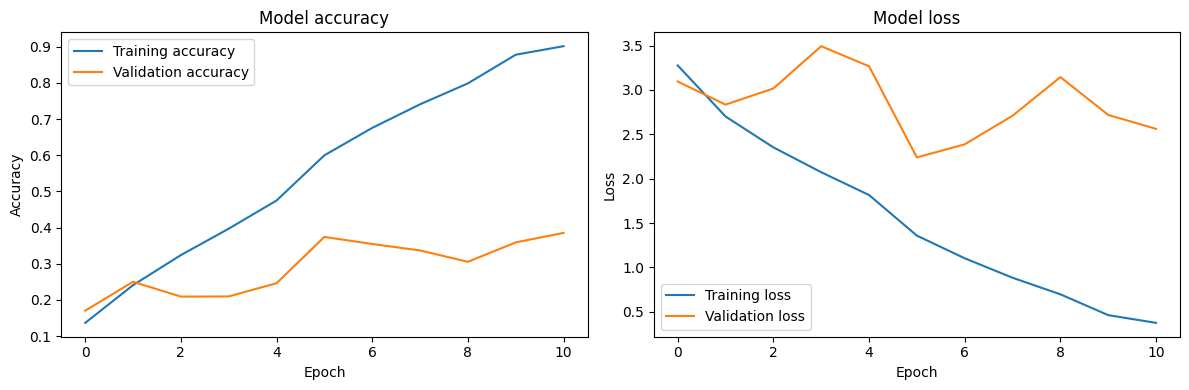

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


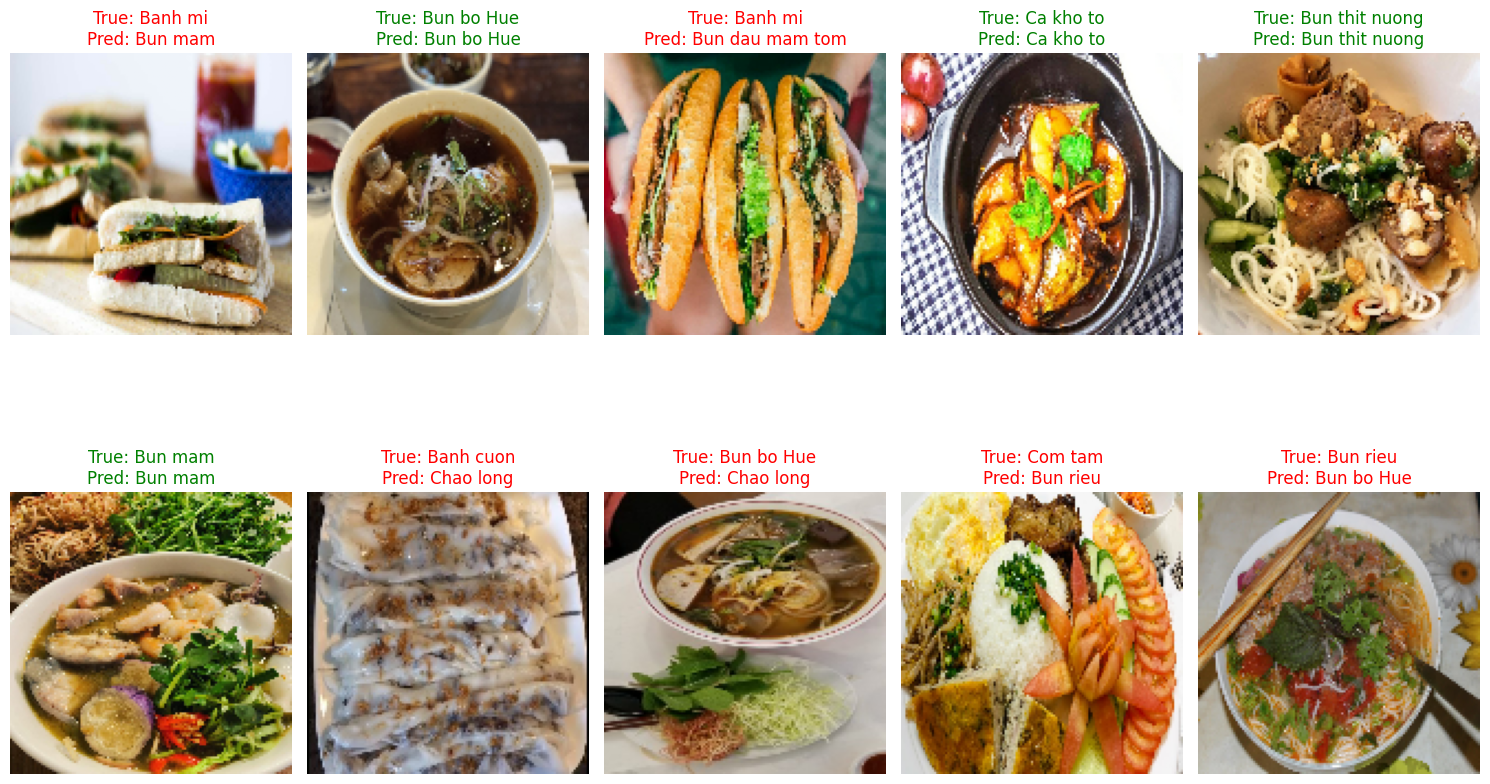

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=final_model.

In [4]:
# Load the best model
model = tf.keras.models.load_model('best_model.h5')

# Evaluate on test set
test_loss, test_acc, test_top3_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test top-3 accuracy: {test_top3_acc:.4f}")

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

plot_history(history)

# Function to visualize predictions
def visualize_predictions(model, dataset, class_names, num_images=10):
    images, labels = next(iter(dataset))
    predictions = model.predict(images)
    
    plt.figure(figsize=(15, 10))
    for i in range(min(num_images, len(images))):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i])
        
        true_class_idx = np.argmax(labels[i])
        pred_class_idx = np.argmax(predictions[i])
        
        color = 'green' if true_class_idx == pred_class_idx else 'red'
        
        plt.title(f"True: {class_names[true_class_idx]}\nPred: {class_names[pred_class_idx]}", 
                 color=color)
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('prediction_examples.png')
    plt.show()

# Visualize some predictions
visualize_predictions(model, test_ds, class_names)

# Save the model for future use
model.save('final_model')
print("Model saved successfully!")